In [1]:
import os
import re
import random
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
    confusion_matrix,
    roc_curve,
)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cpu')

In [4]:
DATA_DIR = "."  
TRUE_PATH = os.path.join(DATA_DIR, "./True.csv")
FAKE_PATH = os.path.join(DATA_DIR, "./Fake.csv")

USE_TITLE = True          
MAX_VOCAB_SIZE = 30000   
MIN_FREQ = 2             
MAX_LEN = 300           

BATCH_SIZE = 64
NUM_EPOCHS = 5            
LR = 1e-3
DROPOUT = 0.2

EMB_DIM = 100
HIDDEN_DIM = 128
NUM_LAYERS = 1
BIDIRECTIONAL_LSTM = True  

PRINT_EVERY = 100         

PAD_TOKEN = "<pad>"
UNK_TOKEN = "<unk>"

PAD_IDX = 0
UNK_IDX = 1

In [6]:

df_true = pd.read_csv(TRUE_PATH)
df_fake = pd.read_csv(FAKE_PATH)

# Add labels: 0 = real (True.csv), 1 = fake (Fake.csv)
df_true["label"] = 0
df_fake["label"] = 1

df = pd.concat([df_true, df_fake], ignore_index=True)

df = df.sample(frac=1.0, random_state=SEED).reset_index(drop=True)

print("Total samples:", len(df))
print("Real news:", (df.label == 0).sum())
print("Fake news:", (df.label == 1).sum())
df.head()

Total samples: 28142
Real news: 4661
Fake news: 23481


,title,text,subject,date,label
0,BREAKING: Trump Unveils First Ad Focusing On T...,Donald Trump revealed his first ad of the poli...,politics,"Jan 4, 2016",1
1,Trump Targets Clean Water And Clean Air Regul...,It s official. Donald Trump is literally tryin...,News,"January 25, 2017",1
2,WILL JULIAN ASSANGE BE ASSASSINATED Before He ...,"Besides Trump, no one has a bigger target on h...",left-news,"Sep 5, 2016",1
3,OBAMA’S OPEN BORDERS Crisis Just Got Real…WHO ...,We recently reported about the deadly Zika vir...,left-news,"Jan 29, 2016",1
4,UNREAL! NEW YORK TIMES Blames Conservatives Fo...,Typical! The New York Times tries to blame con...,left-news,"Apr 27, 2017",1


In [7]:
def clean_text(text: str) -> str:
    """Simple text cleaning:
    - lowercasing
    - remove non-letter characters except basic punctuation (keeps . , ! ? ; :)
    - collapse multiple spaces
    """
    if not isinstance(text, str):
        text = str(text)
    text = text.lower()
    text = re.sub(r"[^a-z0-9\.,!?;:\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text


def tokenize(text: str):
    """Very simple whitespace tokenizer. 
    You can plug in NLTK / spaCy here if you want."""
    return text.split()


if 'title' in df.columns:
    df['title'] = df['title'].fillna('')
else:
    df['title'] = ''
if 'text' in df.columns:
    df['text'] = df['text'].fillna('')
else:
    df['text'] = ''

def prepare_text_column(row):
    title = row.get('title', '')
    text_val = row.get('text', '')
    if pd.isna(title):
        title = ''
    if pd.isna(text_val):
        text_val = ''
    if USE_TITLE:
        full = f"{title} {text_val}"
    else:
        full = text_val
    return clean_text(full)


df["full_text"] = df.apply(prepare_text_column, axis=1)

df[["full_text", "label"]].head()

,full_text,label
0,breaking: trump unveils first ad focusing on t...,1
1,trump targets clean water and clean air regula...,1
2,will julian assange be assassinated before he ...,1
3,obama s open borders crisis just got real who ...,1
4,unreal! new york times blames conservatives fo...,1


In [8]:
def build_vocab(texts, max_size=MAX_VOCAB_SIZE, min_freq=MIN_FREQ):
    counter = Counter()
    for txt in texts:
        tokens = tokenize(txt)
        counter.update(tokens)
    sorted_tokens = [tok for tok, freq in counter.most_common() if freq >= min_freq]
    if max_size is not None:
        sorted_tokens = sorted_tokens[: max_size - 2]  
    idx2token = [PAD_TOKEN, UNK_TOKEN] + sorted_tokens
    token2idx = {tok: idx for idx, tok in enumerate(idx2token)}
    return token2idx, idx2token


token2idx, idx2token = build_vocab(df["full_text"].tolist())
vocab_size = len(idx2token)
print("Vocab size:", vocab_size)


def encode_text(text, token2idx=token2idx, max_len=MAX_LEN):
    tokens = tokenize(text)
    idxs = [token2idx.get(tok, UNK_IDX) for tok in tokens]
    if len(idxs) < max_len:
        idxs = idxs + [PAD_IDX] * (max_len - len(idxs))
    else:
        idxs = idxs[:max_len]
    return np.array(idxs, dtype=np.int64)

encoded_texts = np.stack(df["full_text"].apply(encode_text).values)
labels = df["label"].values.astype(np.int64)

print("Encoded texts shape:", encoded_texts.shape)
print("Labels shape:", labels.shape)

Vocab size: 30000
Encoded texts shape: (28142, 300)
Labels shape: (28142,)


In [9]:
X_temp, X_test, y_temp, y_test = train_test_split(
    encoded_texts, labels, test_size=0.1, random_state=SEED, stratify=labels
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1111, random_state=SEED, stratify=y_temp
)  

print("Train size:", len(X_train))
print("Val size:", len(X_val))
print("Test size:", len(X_test))

Train size: 22513
Val size: 2814
Test size: 2815


In [10]:
class NewsDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


train_dataset = NewsDataset(X_train, y_train)
val_dataset = NewsDataset(X_val, y_val)
test_dataset = NewsDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=torch.cuda.is_available())
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=torch.cuda.is_available())
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=torch.cuda.is_available())

len(train_loader), len(val_loader), len(test_loader)

(352, 44, 44)

In [11]:
class SimpleRNNClassifier(nn.Module):
    def __init__(
        self, vocab_size, emb_dim, hidden_dim,
        num_layers=1, dropout=0.2, padding_idx=PAD_IDX
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=padding_idx)
        self.rnn = nn.RNN(
            input_size=emb_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            nonlinearity='tanh',
            dropout=(dropout if num_layers > 1 else 0.0),
        )
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        emb = self.embedding(x)         
        out, h_n = self.rnn(emb)       
        last = h_n[-1]                  
        logits = self.fc(last).squeeze(1)
        probs = torch.sigmoid(logits)
        return probs, logits


class LSTMClassifier(nn.Module):
    def __init__(
        self, vocab_size, emb_dim, hidden_dim,
        num_layers=1, bidirectional=False, dropout=0.2, padding_idx=PAD_IDX
    ):
        super().__init__()
        self.bidirectional = bidirectional
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=padding_idx)
        self.lstm = nn.LSTM(
            input_size=emb_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=(dropout if num_layers > 1 else 0.0),
        )
        factor = 2 if bidirectional else 1
        self.fc = nn.Linear(hidden_dim * factor, 1)

    def forward(self, x):
        emb = self.embedding(x)                 
        out, (h_n, c_n) = self.lstm(emb)
        if self.bidirectional:
            last_forward = h_n[-2]
            last_backward = h_n[-1]
            last = torch.cat([last_forward, last_backward], dim=1) 
        else:
            last = h_n[-1]                     
        logits = self.fc(last).squeeze(1)     
        probs = torch.sigmoid(logits)
        return probs, logits

In [12]:
def compute_metrics(y_true, y_prob, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)
    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", zero_division=0
    )
    try:
        roc_auc = roc_auc_score(y_true, y_prob)
    except ValueError:
        roc_auc = float('nan')
    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc": roc_auc,
    }


def run_epoch(model, data_loader, criterion, optimizer=None):
    """If optimizer is None => evaluation mode."""
    if optimizer is None:
        model.eval()
    else:
        model.train()

    epoch_loss = 0.0
    all_probs = []
    all_labels = []

    for i, (x_batch, y_batch) in enumerate(data_loader):
        x_batch = x_batch.to(DEVICE)
        y_batch = y_batch.to(DEVICE).float() 

        if optimizer is not None:
            optimizer.zero_grad()

        with torch.set_grad_enabled(optimizer is not None):
            probs, logits = model(x_batch)
            loss = criterion(logits, y_batch)
            if optimizer is not None:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
                optimizer.step()

        epoch_loss += loss.item() * x_batch.size(0)
        all_probs.append(probs.detach().cpu().numpy())
        all_labels.append(y_batch.detach().cpu().numpy())

    epoch_loss /= len(data_loader.dataset)
    all_probs = np.concatenate(all_probs)
    all_labels = np.concatenate(all_labels).astype(int)
    metrics = compute_metrics(all_labels, all_probs)

    return epoch_loss, metrics, all_probs, all_labels


def train_model(model, train_loader, val_loader, num_epochs=NUM_EPOCHS, lr=LR):
    model.to(DEVICE)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    history = {
        "train_loss": [],
        "val_loss": [],
        "train_f1": [],
        "val_f1": [],
        "val_roc_auc": [],
    }

    best_val_f1 = -1.0
    best_state = None

    for epoch in range(1, num_epochs + 1):
        train_loss, train_metrics, _, _ = run_epoch(
            model, train_loader, criterion, optimizer=optimizer
        )
        val_loss, val_metrics, _, _ = run_epoch(
            model, val_loader, criterion, optimizer=None
        )

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_f1"].append(train_metrics["f1"])
        history["val_f1"].append(val_metrics["f1"])
        history["val_roc_auc"].append(val_metrics["roc_auc"])

        print(
            f"Epoch {epoch}/{num_epochs} | "
            f"train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, "
            f"train_f1={train_metrics['f1']:.4f}, val_f1={val_metrics['f1']:.4f}, "
            f"val_roc_auc={val_metrics['roc_auc']:.4f}"
        )

        if val_metrics["f1"] > best_val_f1:
            best_val_f1 = val_metrics["f1"]
            best_state = model.state_dict()

    if best_state is not None:
        model.load_state_dict(best_state)

    return model, history

In [13]:
def run_experiment(
    model_type="rnn",
    emb_dim=EMB_DIM,
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS,
    bidirectional_lstm=BIDIRECTIONAL_LSTM,
    dropout=DROPOUT,
    num_epochs=NUM_EPOCHS,
    lr=LR,
):
    if model_type.lower() == "rnn":
        model = SimpleRNNClassifier(
            vocab_size=vocab_size,
            emb_dim=emb_dim,
            hidden_dim=hidden_dim,
            num_layers=num_layers,
            dropout=dropout,
            padding_idx=PAD_IDX,
        )
    elif model_type.lower() == "lstm":
        model = LSTMClassifier(
            vocab_size=vocab_size,
            emb_dim=emb_dim,
            hidden_dim=hidden_dim,
            num_layers=num_layers,
            bidirectional=bidirectional_lstm,
            dropout=dropout,
            padding_idx=PAD_IDX,
        )
    else:
        raise ValueError("model_type must be 'rnn' or 'lstm'")

    print(f"\n=== Training {model_type.upper()} model ===")
    model, history = train_model(
        model,
        train_loader,
        val_loader,
        num_epochs=num_epochs,
        lr=lr,
    )

    criterion = nn.BCEWithLogitsLoss()
    test_loss, test_metrics, test_probs, test_labels = run_epoch(
        model, test_loader, criterion, optimizer=None
    )

    print("\n=== Test results for", model_type.upper(), "===")
    print("Test loss:", round(test_loss, 4))
    for k, v in test_metrics.items():
        print(f"{k}: {v:.4f}")

    results = {
        "model": model,
        "history": history,
        "test_loss": test_loss,
        "test_metrics": test_metrics,
        "test_probs": test_probs,
        "test_labels": test_labels,
    }
    return results

In [14]:
QUICK_RUN = True  # change to False to run full experiments
SMOKE_TRAIN_SIZE = 5000
SMOKE_VAL_SIZE = 1000
SMOKE_TEST_SIZE = 1000

_orig_train_loader, _orig_val_loader, _orig_test_loader = train_loader, val_loader, test_loader

if QUICK_RUN:
    N = min(SMOKE_TRAIN_SIZE, len(X_train))
    rng = np.random.RandomState(SEED)
    idx = rng.choice(len(X_train), size=N, replace=False)
    X_tr_small = X_train[idx]
    y_tr_small = y_train[idx]
    idx_val = rng.choice(len(X_val), size=min(SMOKE_VAL_SIZE, len(X_val)), replace=False)
    X_val_small = X_val[idx_val]
    y_val_small = y_val[idx_val]
    idx_test = rng.choice(len(X_test), size=min(SMOKE_TEST_SIZE, len(X_test)), replace=False)
    X_test_small = X_test[idx_test]
    y_test_small = y_test[idx_test]

    train_loader = DataLoader(NewsDataset(X_tr_small, y_tr_small), batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=torch.cuda.is_available())
    val_loader = DataLoader(NewsDataset(X_val_small, y_val_small), batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=torch.cuda.is_available())
    test_loader = DataLoader(NewsDataset(X_test_small, y_test_small), batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=torch.cuda.is_available())
    train_loader = DataLoader(NewsDataset(X_tr_small, y_tr_small), batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=torch.cuda.is_available())
    val_loader = DataLoader(NewsDataset(X_val_small, y_val_small), batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=torch.cuda.is_available())
    test_loader = DataLoader(NewsDataset(X_test_small, y_test_small), batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=torch.cuda.is_available())

run_epochs = 1 if QUICK_RUN else NUM_EPOCHS

try:
    rnn_results = run_experiment(
        model_type="rnn",
        emb_dim=EMB_DIM,
        hidden_dim=HIDDEN_DIM,
        num_layers=NUM_LAYERS,
        dropout=DROPOUT,
        num_epochs=run_epochs,
        lr=LR,
    )
except KeyboardInterrupt:
    print("RNN training interrupted by user")
    rnn_results = None

try:
    lstm_results = run_experiment(
        model_type="lstm",
        emb_dim=EMB_DIM,
        hidden_dim=HIDDEN_DIM,
        num_layers=NUM_LAYERS,
        bidirectional_lstm=BIDIRECTIONAL_LSTM,
        dropout=DROPOUT,
        num_epochs=run_epochs,
        lr=LR,
    )
except KeyboardInterrupt:
    print("LSTM training interrupted by user")
    lstm_results = None

train_loader, val_loader, test_loader = _orig_train_loader, _orig_val_loader, _orig_test_loader

print(f'Done (quick_run={QUICK_RUN}).')


=== Training RNN model ===
Epoch 1/1 | train_loss=0.4723, val_loss=0.4353, train_f1=0.8997, val_f1=0.9154, val_roc_auc=0.5341

=== Test results for RNN ===
Test loss: 0.4404
accuracy: 0.8360
precision: 0.8360
recall: 1.0000
f1: 0.9107
roc_auc: 0.5864

=== Training LSTM model ===
Epoch 1/1 | train_loss=0.2779, val_loss=0.0433, train_f1=0.9415, val_f1=0.9976, val_roc_auc=1.0000

=== Test results for LSTM ===
Test loss: 0.0456
accuracy: 0.9950
precision: 0.9941
recall: 1.0000
f1: 0.9970
roc_auc: 1.0000
Done (quick_run=True).


Short history values:
RNN history: {'train_loss': [0.4722939923286438], 'val_loss': [0.43528563737869264], 'train_f1': [0.8996685082872928], 'val_f1': [0.9154013015184381], 'val_roc_auc': [0.534136134402722]}
LSTM history: {'train_loss': [0.27791671547889707], 'val_loss': [0.043261259973049165], 'train_f1': [0.9415467625899281], 'val_f1': [0.9976359338061466], 'val_roc_auc': [0.9999772147283996]}


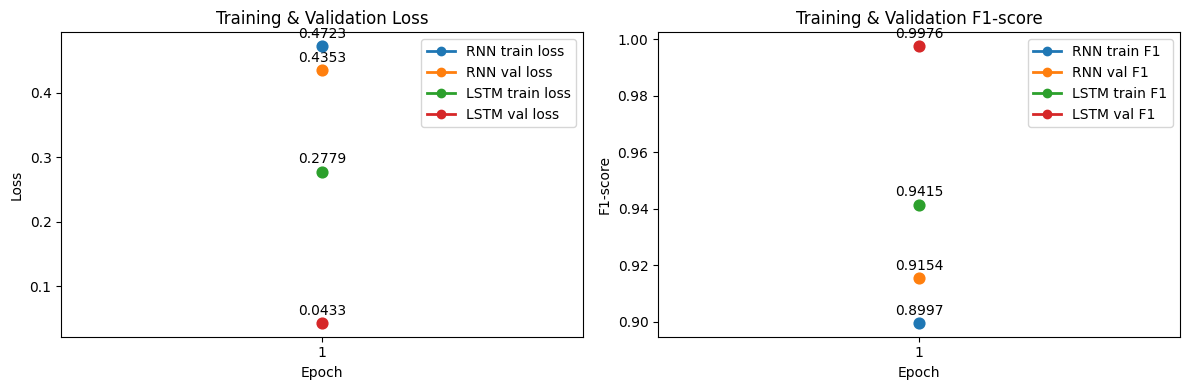

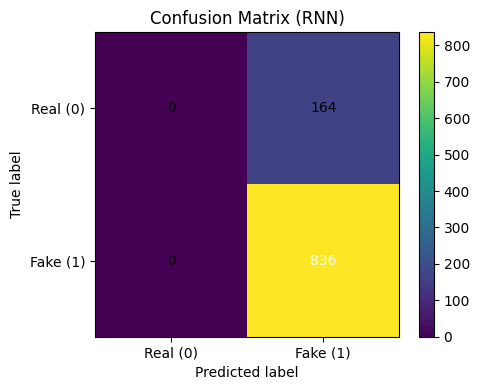

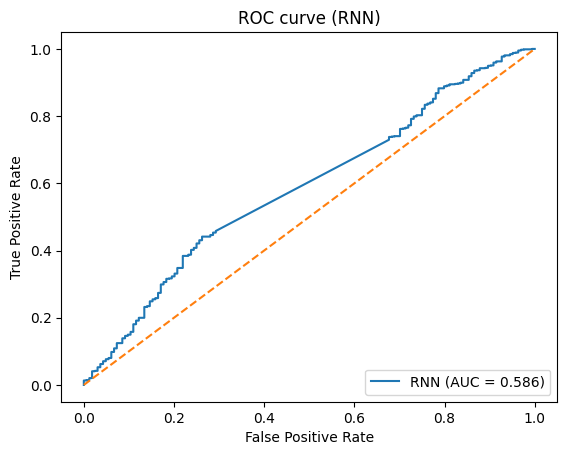

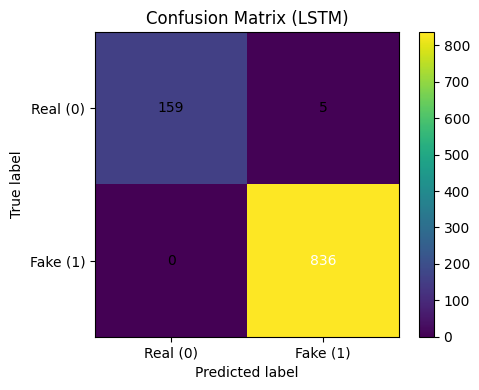

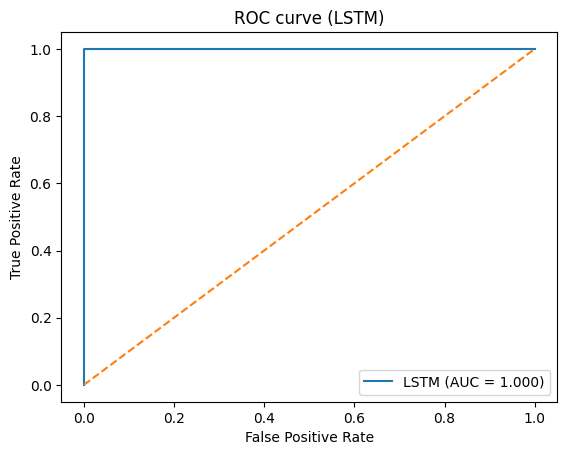

In [15]:
def plot_history(history_rnn, history_lstm):
    """Plot training/validation loss and F1 for RNN and LSTM."""
    def _get(h, key):
        return list(h.get(key, [])) if isinstance(h, dict) else []

    train_loss_r = _get(history_rnn, 'train_loss')
    val_loss_r = _get(history_rnn, 'val_loss')
    train_loss_l = _get(history_lstm, 'train_loss')
    val_loss_l = _get(history_lstm, 'val_loss')

    train_f1_r = _get(history_rnn, 'train_f1')
    val_f1_r = _get(history_rnn, 'val_f1')
    train_f1_l = _get(history_lstm, 'train_f1')
    val_f1_l = _get(history_lstm, 'val_f1')

    n_epochs = max(len(train_loss_r), len(train_loss_l), len(train_f1_r), len(train_f1_l), 1)
    epochs = list(range(1, n_epochs + 1))

    plt.figure(figsize=(12, 4))
    def safe_plot(xs, ys, label, **kwargs):
        if len(ys) == 0:
            return
        plt.plot(xs[:len(ys)], ys, label=label, marker='o', linewidth=2, **kwargs)
        if len(ys) == 1:
            plt.scatter(xs[0], ys[0], s=60, zorder=5)
            try:
                plt.annotate(f"{ys[0]:.4f}", (xs[0], ys[0]), textcoords="offset points", xytext=(0, 6), ha="center")
            except Exception:
                pass

    plt.subplot(1, 2, 1)
    safe_plot(epochs, train_loss_r, 'RNN train loss')
    safe_plot(epochs, val_loss_r, 'RNN val loss')
    safe_plot(epochs, train_loss_l, 'LSTM train loss')
    safe_plot(epochs, val_loss_l, 'LSTM val loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss')
    plt.xticks(epochs)
    plt.legend()

    plt.subplot(1, 2, 2)
    safe_plot(epochs, train_f1_r, 'RNN train F1')
    safe_plot(epochs, val_f1_r, 'RNN val F1')
    safe_plot(epochs, train_f1_l, 'LSTM train F1')
    safe_plot(epochs, val_f1_l, 'LSTM val F1')
    plt.xlabel('Epoch')
    plt.ylabel('F1-score')
    plt.title('Training & Validation F1-score')
    plt.xticks(epochs)
    plt.legend()

    plt.tight_layout()
    if n_epochs <= 2:
        print('Short history values:')
        print('RNN history:', history_rnn)
        print('LSTM history:', history_lstm)
    plt.show()


def plot_confusion_and_roc(results, model_name="Model"):
    y_true = results["test_labels"]
    y_prob = results["test_probs"]
    y_pred = (y_prob >= 0.5).astype(int)

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    plt.imshow(cm, interpolation="nearest")
    plt.title(f"Confusion Matrix ({model_name})")
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ["Real (0)", "Fake (1)"])
    plt.yticks(tick_marks, ["Real (0)", "Fake (1)"])
    plt.xlabel("Predicted label")
    plt.ylabel("True label")

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha="center", va="center", color="white" if cm[i, j] > cm.max() / 2. else "black")

    plt.tight_layout()
    plt.show()

    try:
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        roc_auc = roc_auc_score(y_true, y_prob)
        plt.figure()
        plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.3f})")
        plt.plot([0, 1], [0, 1], linestyle="--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC curve ({model_name})")
        plt.legend(loc="lower right")
        plt.show()
    except ValueError:
        print("ROC curve cannot be computed (only one class present?).")


if 'rnn_results' in globals() and rnn_results is not None and 'lstm_results' in globals() and lstm_results is not None:
    try:
        plot_history(rnn_results['history'], lstm_results['history'])
    except Exception as e:
        print('Could not plot history:', e)

if 'rnn_results' in globals() and rnn_results is not None:
    try:
        plot_confusion_and_roc(rnn_results, model_name='RNN')
    except Exception as e:
        print('Could not plot RNN confusion/ROC:', e)
else:
    print('rnn_results missing or training was interrupted; skipping RNN plots')

if 'lstm_results' in globals() and lstm_results is not None:
    try:
        plot_confusion_and_roc(lstm_results, model_name='LSTM')
    except Exception as e:
        print('Could not plot LSTM confusion/ROC:', e)
else:
    print('lstm_results missing or training was interrupted; skipping LSTM plots')